# <span style="color:blue;"> Algorithm for automatic detection of counterfeit banknotes</span>

## Import the libraries

In [103]:
# Import the libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from Functions import graph_box_plots, backward_selected, backward_selected_log_reg
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_percentage_error, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# <span style="color:blue;">Data preparation and cleaning</span>

### Preparation

In [104]:
# Import the file
billets = pd.read_csv('billets.csv', sep=';')

Here, I will check the shape and see the head of the dataframe. Then, I will check the type of each variable.

In [105]:
# Check df shape
billets.shape

(1500, 7)

In [106]:
# Check df head
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [107]:
# Check data type of each column
billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

### Missing values

In [108]:
# Search for null values
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

There are 37 null values. I'm going to use a linear regression to impute the missing values, as required by the Openclassrooms project guidelines.

### Numerisation - Replace 'True' and 'False' values with 1 and 0

In [109]:
# Check if there are just two values for column 'is_genuine'
billets['is_genuine'].unique()

array([ True, False])

In [110]:
# Replace True and False with 0 and 1
billets['is_genuine'] = billets['is_genuine'].replace(False, 0)
billets['is_genuine'] = billets['is_genuine'].replace(True, 1)
billets['is_genuine'] = billets['is_genuine'].astype('int')

C:\Users\floss\AppData\Local\Temp\ipykernel_732\3704697007.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  billets['is_genuine'] = billets['is_genuine'].replace(True, 1)


### Search for outliers

In [111]:
#Create a df with only the true banknotes
vrais_billets = billets.loc[billets['is_genuine']==1]

#Create a df with only the fake banknotes
faux_billets = billets.loc[billets['is_genuine']==0]

#Visualise the statistics for the true and the fank banknotes
print("Values for the real banknotes")
display(vrais_billets.describe())
print('--------------------------------------------------------------------')
print("Values for the fake banknotes")
display(faux_billets.describe())

Values for the real banknotes


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.0,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,1.0,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.0,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,1.0,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,1.0,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,1.0,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,1.0,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,1.0,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


--------------------------------------------------------------------
Values for the fake banknotes


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.0,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,0.0,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.0,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,0.0,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,0.0,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,0.0,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,0.0,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,0.0,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


Although there are variables with large maximum sizes or small minimum sizes, the values do not appear to be outliers.

The standard deviations of fake banknotes for margin_low and length are much larger than for real ones.

# <span style="color:blue;">Descriptive Analysis</span>



### Count of real and fake banknotes

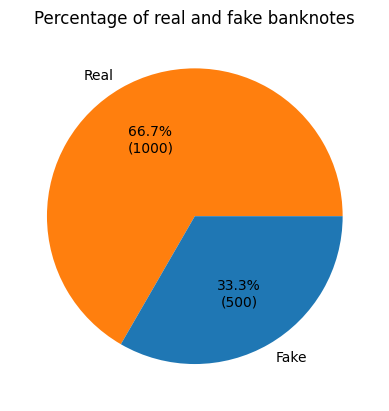

In [112]:
#Visualise the percentage of real and fake banknotes
counts = billets['is_genuine'].value_counts()
labels = ['Real', 'Fake']
colors=['tab:orange', 'tab:blue']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

plt.pie(counts, labels=labels, colors=colors, autopct=autopct_format(counts))
plt.title("Percentage of real and fake banknotes")
plt.show()

- Real banknotes: 1000
- Fake banknotes: 500

### Boxplots for each predictive variable by 'is_genuine'

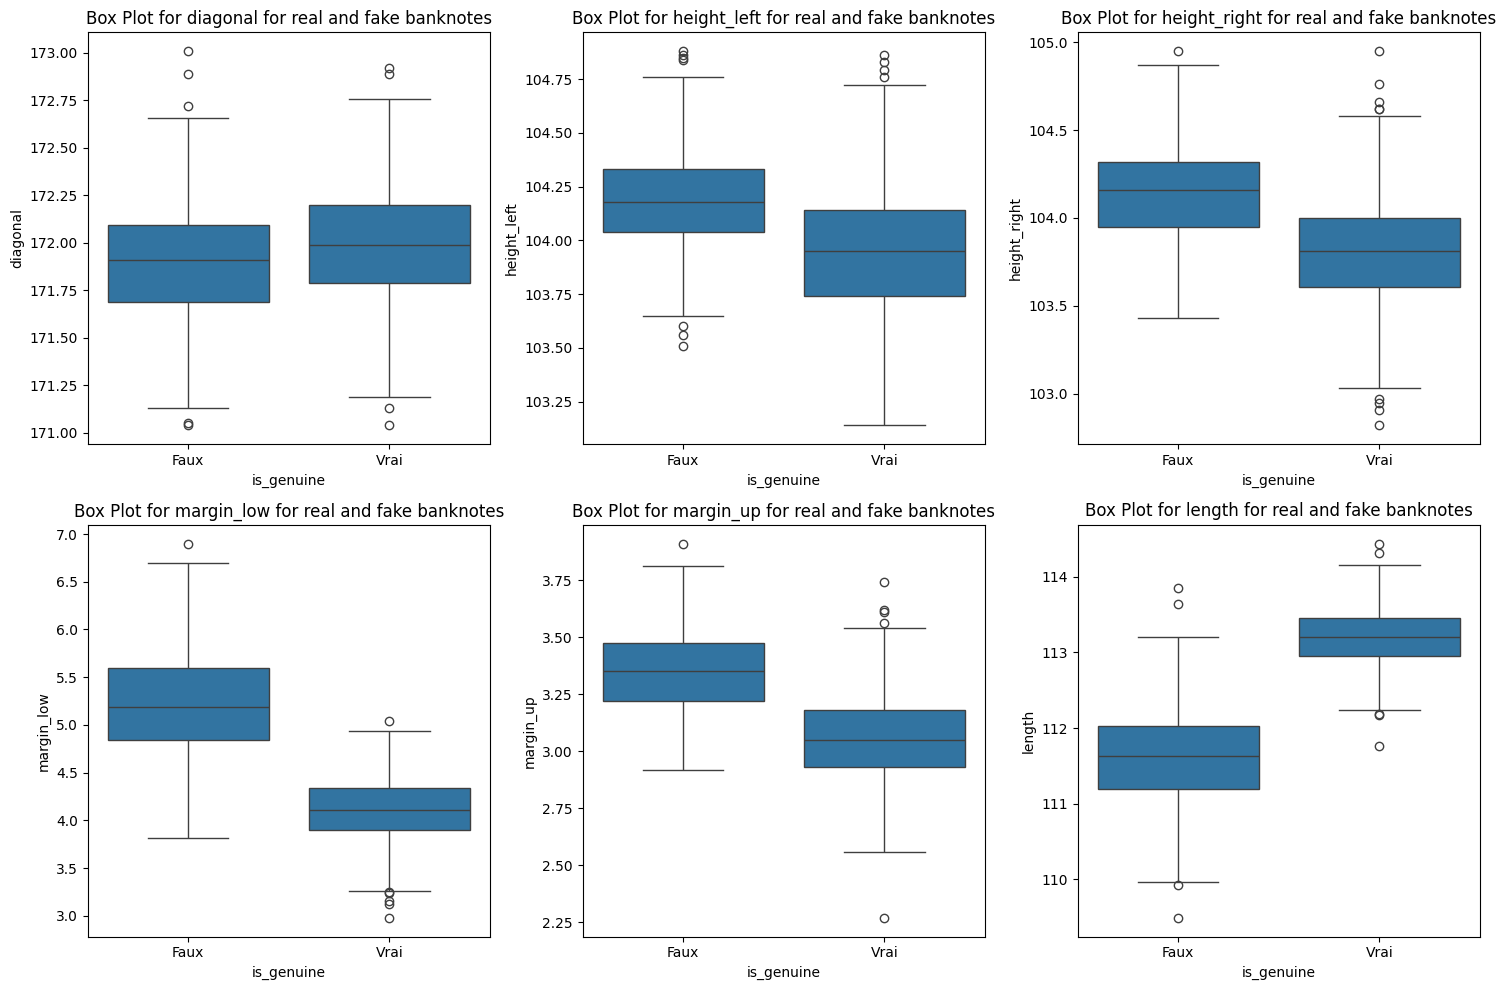

In [113]:
#Visualise the distribution of the banknotes' dimensions
columns = ['diagonal','height_left','height_right','margin_low','margin_up','length']

graph_box_plots(billets, columns)

#### Comparison of the dimensions of real and fake banknotes
- “Diagonal” dimensions are very similar
- The dimensions of “height_left” and “height_right” are also relatively similar.
- On the other hand, the dimensions for “length” and “margin_low” are very different for real and fake banknotes. This suggests a link between the reality of a ticket and these variables.
- The dimensions of “margin_up” are also relatively distinct for real and fake banknotes.

### Correlation matrix

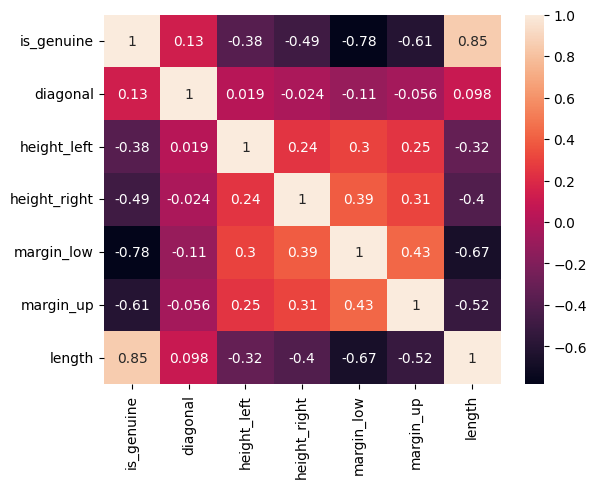

In [114]:
#Create a correlation matrix
correlation_matrix = billets.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

A correlation matrix tells us how well each variable is correlated with other variables in the database.

#### Length, margin_low and margin_up are the 3 variables most correlated with is_genuine.
- length - positive correlation of 0.85 - banknotes with a longer length are more likely to be true.
- margin_low - negative correlation of -0.78 - banknotes with a larger bottom margin are more likely to be fake.
- margin_up - negative correlation of -0.61 - banknotes with a larger margin-up are more likely to be fake.
#### Diagonal is the least correlated variable with is_genuine
- diagonal - negative correlation of -0.13

### Pairplot

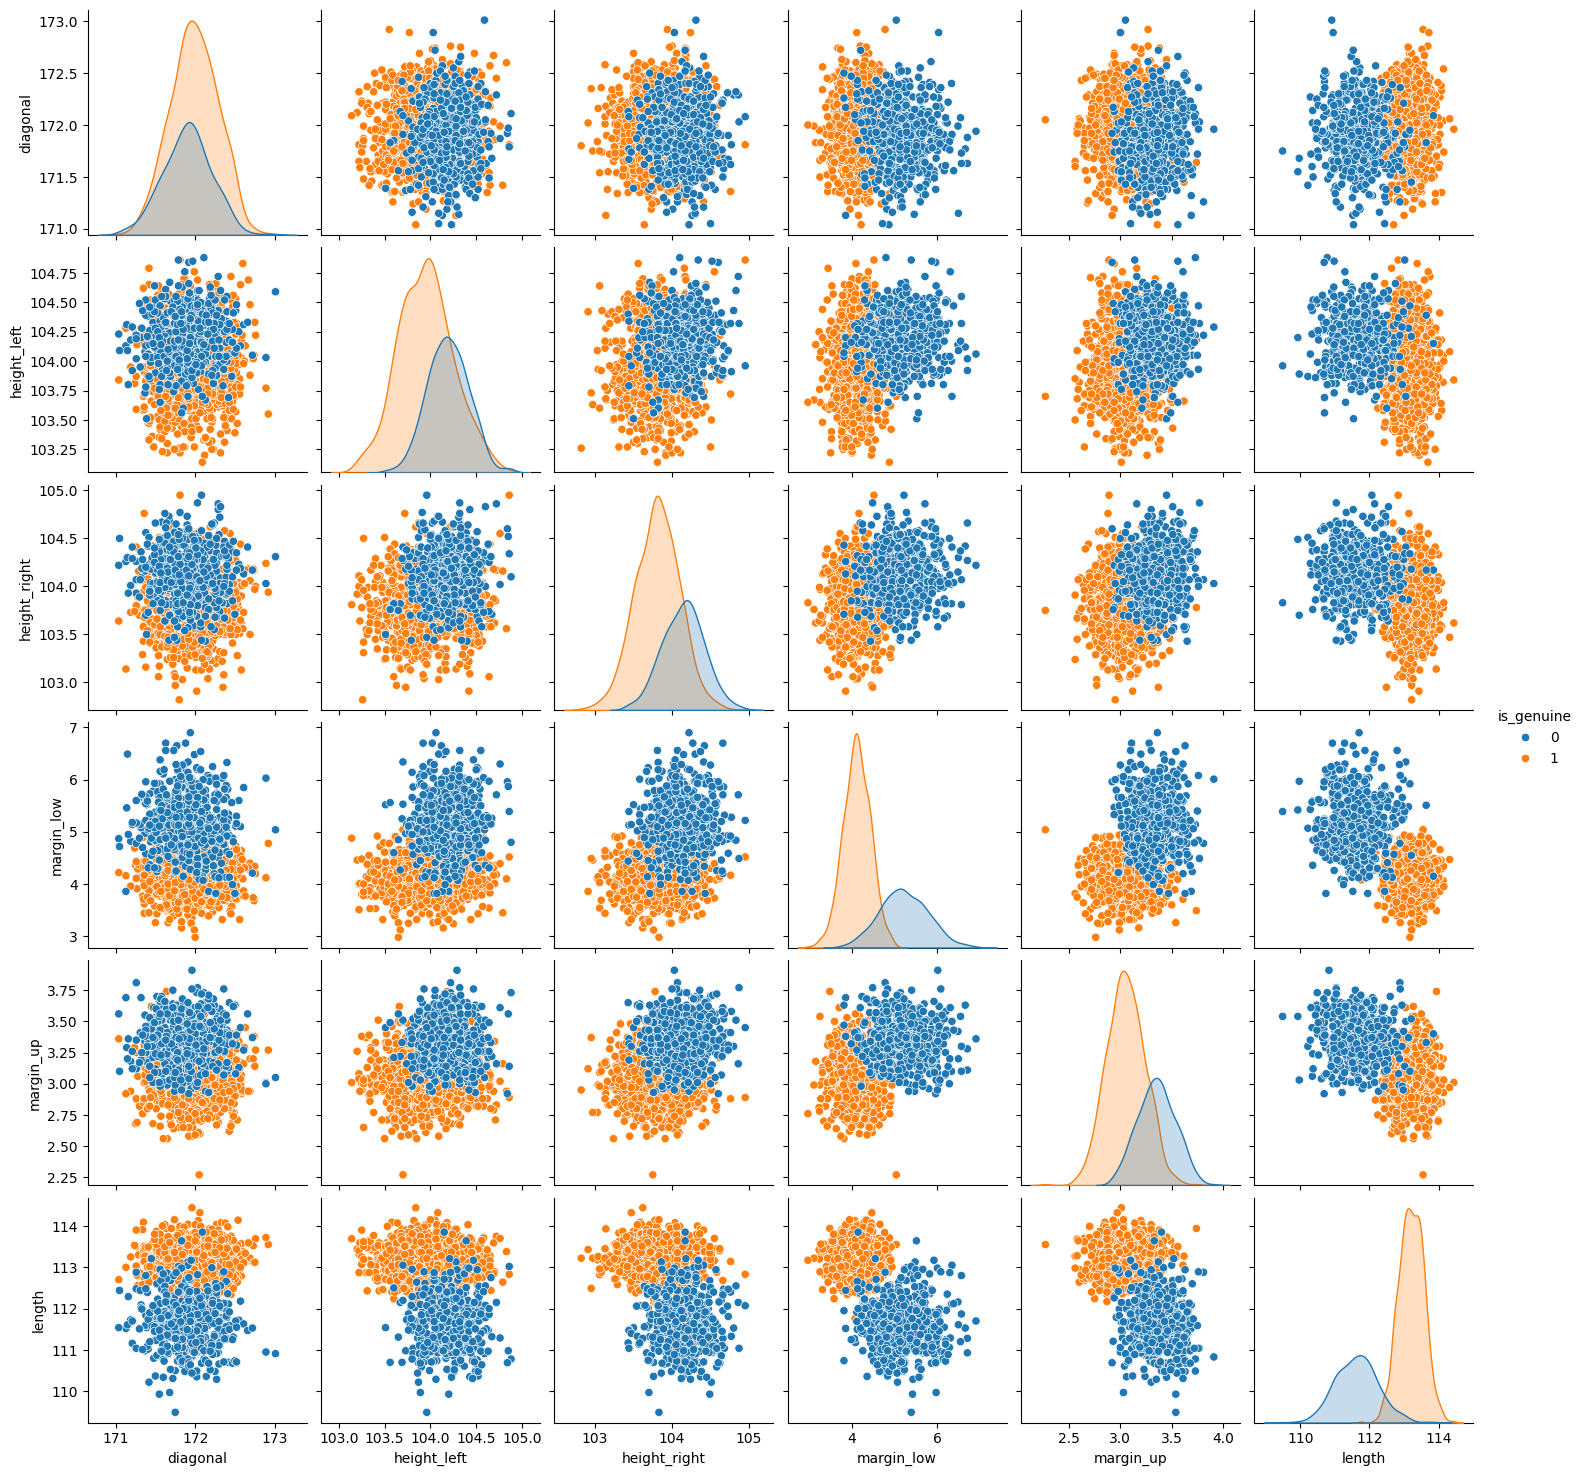

In [115]:
#Create a pairplot
sns.pairplot(billets, hue='is_genuine')

A pairplot visualizes the relationship between each variable in a dataframe.

#### Diagonal graphics
The diagonal graphs show the distribution of each variable for counterfeit notes (0), and real notes (1)
- Length and margin_up have clear distinctions between real and fake banknotes. This suggests that these would be good predictive variables
- There are no clear distinctions between real and fake banknotes for "diagonal". The distinctions for height_left and height_right aren't clear either.
#### Scatterplots
- Scatterplots with length as a variable have fairly well separated clusters, especially length and margin_low. This suggested that length could contribute significantly to determining which banknotes are real and which banknotes are fake.
- The scatterplot with margin_low and margin_up have clusters that are also quite well separated.

### Results

There seems to be a relationship between "is_genuine" and "length", "margin_low" and "margin_up".

On the other hand, “diagonal” doesn’t seem to have a strong correlation with “is_genuine”. “height_left” and “height_right” also appear to have relatively low correlations with “is_genuine”.

# <span style="color:blue;"> Null values </span>

In [116]:
print("There are",billets.margin_low.isna().sum(),"null values in the 'margin_low' column")

There are 37 null values in the 'margin_low' column


There are several ways to handle missing values:
#### 'Ignore and remove all samples missing this value'
- Removing tickets with missing values for "margin_low" would reduce the size of our dataset, and since all other variables in the tickets have values, it seems like a waste to remove these individuals.

#### 'Replace missing values with a specific value that indicates the value is not available. For example -1 or 0 for numbers or None for a category.'
- Replacing missing values with a specific value (e.g. 0 or -1) may negatively affect the models I create later.

#### 'Infer the missing values from the available values... We can for example take the average of the available values or construct a linear regression from the other variables.'
- Inferring missing data seems to be the best way to go. While taking the average of fruit bills and counterfeit bills is a quick and convenient option, a more rigorous approach is to perform a linear regression to find the estimated values for each bank note.
  (https://openclassrooms.com/fr/courses/8063076-initiez-vous-au-machine-learning/8299343-ameliorez-un-jeu-de-dataes)

## <span style="color:blue;">Linear Regression</span>

I'm going to try using linear regression to find fairly precise values.

### Separate the data

In [117]:
# Create a dataframe without banknotes with missing values
not_na_billets = billets.loc[billets['margin_low'].notnull()]

### View the coefficients of the predictive variables

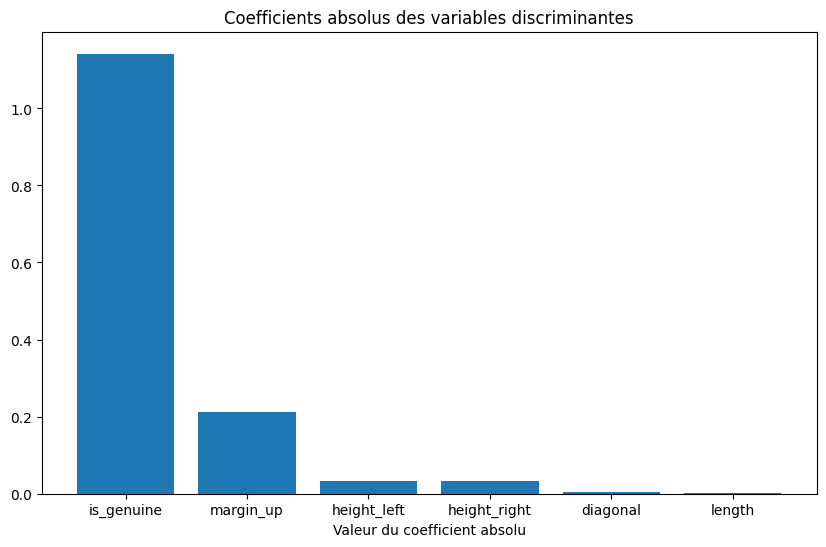

In [118]:
X = not_na_billets.drop(columns='margin_low')
y = not_na_billets.margin_low

# Train the model
test_lin_reg = sm.OLS(y, X)
result = test_lin_reg.fit()

# Create a df with the coefficients of the model
coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': result.params})

# Change the values of the coefficients to their absolute values
coefficients_df['CoefficientAbs'] = abs(coefficients_df['Coefficient'])

# Sort variables in descending order
coefficients_df = coefficients_df.sort_values(by='CoefficientAbs', ascending=False)
coefficients_df = coefficients_df[coefficients_df['Variable'] != 'const']

# View absolute values of variables
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Variable'], coefficients_df['CoefficientAbs'])
plt.xlabel('Valeur du coefficient absolu')
plt.title('Coefficients absolus des variables discriminantes')
plt.show()

This graph shows that the discriminant variable 'is_genuine' influences 'margin_low' by far the most. “Margin_up” has low influence and the other variables have very low levels of influence.

### Remove non-significant variables

In [119]:
# Find the most relevant variables for the model
columns = ['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']
reg_backward = backward_selected(not_na_billets[columns], 'margin_low')

_______________________________
margin_low ~ length + height_left + margin_up + height_right + diagonal + is_genuine + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ height_left + margin_up + height_right + diagonal + is_genuine + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_left + margin_up + height_right + is_genuine + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ height_left + margin_up + is_genuine + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

This function identified the best model is what we saw with the graph above - a model with the two predictor variables "is_genuine" and "margin_up".

#### The model is statistically significant
The p-values are less than 5% (1.24e-304). We therefore reject the hypothesis according to which the parameter is equal to 0 -

#### The R-squared value is 0.617
The model explains approximately 61.7% of the variability of 'margin_low'.

#### Coefficients
is_genuine: -1.1632 - each increase of one unit in "is_genuine" causes a decrease of approximately 1.1632 units in "margin_low". This suggests that real banknotes have lower margins than fake ones.

margin_up: -0.2119 - each increase of one unit in 'margin_up' causes a decrease of approximately 0.2119 units in 'margin_low'. This suggests that a larger bottom margin is associated with a larger top margin.

##  Analysis of results

In [120]:
# Define x and y based on the model above
X = not_na_billets[['is_genuine', 'margin_up']]
X = sm.add_constant(X)
y = not_na_billets['margin_low']

In [121]:
# Train the model
lin_reg_model = sm.OLS(y, X)

# Fit the model
lin_reg_model = lin_reg_model.fit()

In [122]:
# Set significance level (alpha) to 5%
alpha = 0.05

# Number of banknotes
n=not_na_billets.shape[0]

p = 3

#Create a new dataframe for the analysis
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['obs'] = analyses['obs'].astype('float')

###  Cook's distance

Cook's distance combines information about residuals and leverage to measure the influence of each observation on the model's predictions. I'm going to use this to identify outliers and remove them to see if it can help improve linear regression.

In [123]:
# Find Cook's distance
influence = lin_reg_model.get_influence().summary_frame()

# Add Cook's distance to the df
analyses['dcooks'] = influence['cooks_d']

# Calculate the threshold
seuil_dcook = 4/(n-p)

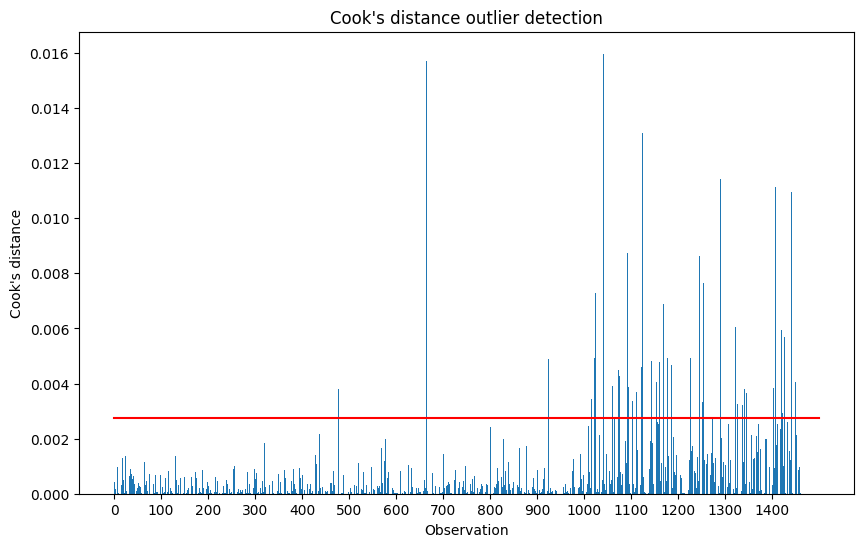

There are 93 values that exceed the Cook's distance threshold.
There are 79 fake banknotes which are outliers and there are 14 real banknotes.


In [124]:
# View Cook's distance and the outliers
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=100))
plt.title("Cook's distance outlier detection")
plt.xlabel('Observation')
plt.ylabel("Cook's distance")
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

#Find the number of outliers
outliers_cooks = analyses.loc[analyses['dcooks'] > seuil_dcook, :]
print('There are', outliers_cooks['dcooks'].count(), "values that exceed the Cook's distance threshold.")
outliers= pd.merge(not_na_billets, outliers_cooks, left_index=True, right_index=True).drop(columns =['obs', 'dcooks'])
print('There are', outliers.loc[outliers['is_genuine']==0, 'is_genuine'].count(), 'fake banknotes which are outliers and there are', outliers.loc[outliers['is_genuine']==1, 'is_genuine'].count(), 'real banknotes.')

The counterfeit outliers are not surprising, as some counterfeits may be less realistic than others. However, the outliers for real banknotes are more surprising.

In [125]:
#Find the real banknotes which are outliers according to Cook's Distance
true_outliers = outliers.loc[outliers['is_genuine']==1,]
print('----------------------------------------------------------------------------')
print('Outliers - Real banknotes')
display(true_outliers.describe())

#Find the real banknotes that are not outliers according to Cook's Distance
print('----------------------------------------------------------------------------')
print("Not outliers - Real banknotes")
true_not_outliers = not_na_billets.drop(true_outliers.index)
display(true_not_outliers.describe())

----------------------------------------------------------------------------
Outliers - Real banknotes


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,1.0,171.864286,103.974286,103.898571,3.875714,2.978571,113.291429
std,0.0,0.264334,0.216145,0.265094,0.751713,0.445557,0.374060
min,1.0,171.340000,103.650000,103.290000,2.980000,2.270000,112.580000
25%,1.0,171.752500,103.777500,103.785000,3.282500,2.702500,113.177500
50%,1.0,171.925000,104.010000,103.885000,3.505000,2.770000,113.280000
75%,1.0,171.960000,104.177500,104.012500,4.727500,3.440000,113.542500
max,1.0,172.450000,104.250000,104.390000,5.040000,3.740000,113.940000


----------------------------------------------------------------------------
Not outliers - Real banknotes


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,0.660455,171.960110,104.031884,103.921698,4.491863,3.154769,112.668799
std,0.473718,0.305763,0.300300,0.324767,0.660454,0.228068,0.874597
min,0.000000,171.040000,103.140000,102.910000,3.120000,2.560000,109.490000
25%,0.000000,171.750000,103.830000,103.710000,4.020000,2.990000,112.010000
50%,1.000000,171.960000,104.040000,103.920000,4.320000,3.140000,112.960000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.330000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.320000


Given the relative difference between real ticket outliers and other real tickets, I will remove real tickets that are outliers.

In [126]:
#Delete the outliers
not_na_billets_2 = not_na_billets[['margin_low', 'is_genuine', 'margin_up']].drop(true_outliers.index)

#Check the results of the regression
lin_reg_model_2 = smf.ols('margin_low~margin_up+is_genuine', data=not_na_billets_2).fit()
print(lin_reg_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1192.
Date:                Tue, 19 Mar 2024   Prob (F-statistic):          1.29e-306
Time:                        15:34:59   Log-Likelihood:                -748.65
No. Observations:                1449   AIC:                             1503.
Df Residuals:                    1446   BIC:                             1519.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0124      0.200     29.995      0.0

#### The model is statistically significant
P-values are less than 5% (0). We therefore reject the hypothesis that the parameter is equal to 0 - the model is statistically significant.

#### The R-squared value is 0.623 instead of 0.617
The model explains approximately 62.3% of the variability of 'margin_low'.

#### Coefficients
is_genuine: -1.1671 - each increase of one unit in "is_genuine" causes a decrease of approximately 1.1671 units in "margin_low". This suggests that real banknotes have lower margins than fake ones.

margin_up: -0.2377 - each increase of one unit in 'margin_up' results in a decrease of approximately 0.2377 units in 'margin_low'. This suggests that a larger bottom margin is associated with a larger top margin.

#### So I will continue on this path and pursue a more in-depth analysis.

### Colinearity of variables

In [127]:
#Check the collinearity between variables and find the variance inflation factor (VIF)
variables = lin_reg_model_2.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.6202616626641901, 1.62026166266419]

- Collinearity is when two variables are too closely correlated (for example, age and months since born). Generally, a VIF below 10 suggests that the correlation between the model's predictor variables is not problematic.
- All coefficients are less than 10, so there is no collinearity problem.

### Homoscedasticity

Homoscedasticity is the assumption that different groups compared to each other have equal or similar variances.

In [128]:
# Check homoscedasticity
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(lin_reg_model_2.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.9624406801134338e-39


The p-value here is less than $5$% - I must reject the $H0$ hypothesis that the variances are constant (the homoscedasticity hypothesis).

### Normality of residuals

In [129]:
# Check if the data follows a normal distribution.
shapiro(lin_reg_model_2.resid)

ShapiroResult(statistic=0.9928435533557542, pvalue=1.767653243315513e-06)

#### Statistic = 0.99
- The closer the statistic is to 1, the more the sample resembles a normal distribution.

#### P-value = 1.764e-06
- The assumption of normality is called into question (pvalue = 1.764e-06 < 0.05). Nevertheless, the observation of the residuals, the fact that they are not very different from a symmetrical distribution, and the fact that the sample is of sufficient size (greater than 30) allow us to say that the results obtained by the model linear Gaussian are not absurd, even if the residual is not considered to be Gaussian.

## Results
- The collinearity test - validated
- The homoscedascity test - not validated
- The test for normality of residuals - not validated

Given the results of this analysis, this model is acceptable for linear regression.
I will use it to find missing values in the 'margin_low' column.

### Create imputed values for cells with missing values

In [130]:
# Create a df with the values of banknotes with null values for 'margin_low'
na_billets = billets.loc[billets["margin_low"].isna()]

#Predict the values of margin_low with the values of the df 'valeurs_nulles'
predicted_value = lin_reg_model_2.predict(na_billets)

#Add these values to the df
billets.loc[billets['margin_low'].isnull(), 'margin_low']=predicted_value

# <span style="color:blue;"> Create a model to determine whether banknotes are real or fake</span>

**The next step is to create a model to determine whether banknotes are real or fake. I will use two types of logistic regression (statsmodel and Scikit-Learn) and k-means and then compare the effectiveness of the three models.**

## <span style="color:blue;">Logistic Regressions</span>

In [131]:
# Define X and y 
X = billets.drop(columns='is_genuine')
y = billets.is_genuine

# Divide the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <span style="color:blue;">1. Statsmodels - Logistic regression</span>
### Find the most pertinent values

Optimization terminated successfully.
         Current function value: 0.026616
         Iterations 12


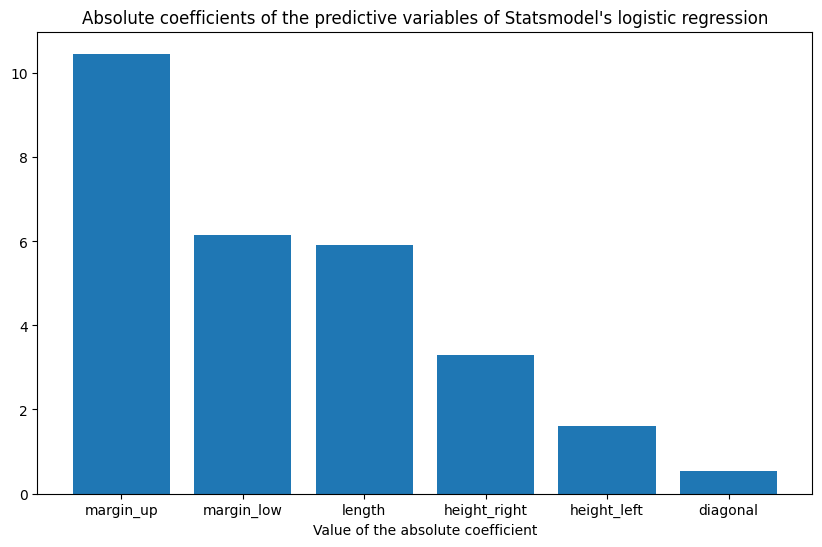

In [132]:
# Train the model
test_sm_log_reg = sm.Logit(y, X)
result = test_sm_log_reg.fit()

# Create a dataframe with the model's coefficients
coefficients_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': result.params})

# Change the values of the coefficients to their absolute values
coefficients_df['CoefficientAbs'] = abs(coefficients_df['Coefficient'])

# Sort variables in descending order
coefficients_df = coefficients_df.sort_values(by='CoefficientAbs', ascending=False)
coefficients_df = coefficients_df[coefficients_df['Variable'] != 'const']

# View absolute values of variables
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Variable'], coefficients_df['CoefficientAbs'])
plt.xlabel('Value of the absolute coefficient')
plt.title("Absolute coefficients of the predictive variables of Statsmodel's logistic regression")
plt.show()

The most relevant variables seem to be 'margin_up', 'margin_low' and 'length'. I can use a function to check if they are the most relevant variables for the model.

In [133]:
# Find the most relevant variables for the model
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
log_reg = backward_selected_log_reg(billets[columns], 'is_genuine')

_______________________________
is_genuine ~ length + height_left + margin_low + margin_up + height_right + diagonal + 1
Optimization terminated successfully.
         Current function value: 0.026324
         Iterations 13
remove diagonal (p-value : 0.813 )

_______________________________
is_genuine ~ length + height_left + margin_low + margin_up + height_right + 1
Optimization terminated successfully.
         Current function value: 0.026343
         Iterations 13
remove height_left (p-value : 0.254 )

_______________________________
is_genuine ~ length + margin_low + margin_up + height_right + 1
Optimization terminated successfully.
         Current function value: 0.026782
         Iterations 13
is the final model !

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1495
Method:                       

This function identified that the best model is actually a model with 4 predictor variables - 'margin_up', 'height_right', 'margin_low' and 'length'.

#### The pseudo R-squared value is 0.9579
The model explains approximately 95.7% of the variability of 'is_genuine'.

#### The model is statistically significant
LLR p-values are less than 5% (0.000).

#### Coefficients
1. margin_up (-10.4098): For each one-unit increase in margin_up, the logarithmic probability that the ticket is true decreases by approximately 10.41. This suggests that the larger the top margin, the less likely it is to be real.

2. 'height_right' (-3.3512): For each one-unit increase in height_right, the logarithmic probability that the ticket is true decreases by approximately 3.35. This suggests that the greater the height of the right hand, the less likely the bill is real.
 
3. 'margin_low' (-6.3058): For each one unit increase in margin_low, the logarithmic probability that the ticket is true decreases by approximately 6.31. This suggests that the larger the bottom margin, the less likely the ticket is real.
 
4. “length” (6.1592): For each unit increase in length, the logarithmic probability that the ticket is true increases by approximately 6.16. This suggests that the lower the margin, the more likely the ticket is real.

### Define model predictor variables and split data into test and train

In [134]:
# Define X and y
X = billets[['height_right','margin_low','margin_up','length']]
y = billets.is_genuine

# Divide the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
sm_log_reg = sm.Logit(y_train, X_train).fit() 

# Make the predictions
y_pred = sm_log_reg.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.030209
         Iterations 11


### Accuracy, Precision, Recall eand ROC-AUC

My next step is to check the accuracy, precision, recall and ROC-AUC for this model.

In [135]:
# Round the prediction to the nearest number (0 or 1)
prediction = list(map(round, y_pred)) 
  
# Create a confusion matrix
cm = confusion_matrix(y_test, prediction)  

Test accuracy =  0.9933333333333333
Precision : 0.9896
Recall : 1.0000
ROC-AUC score : 0.9909090909090909


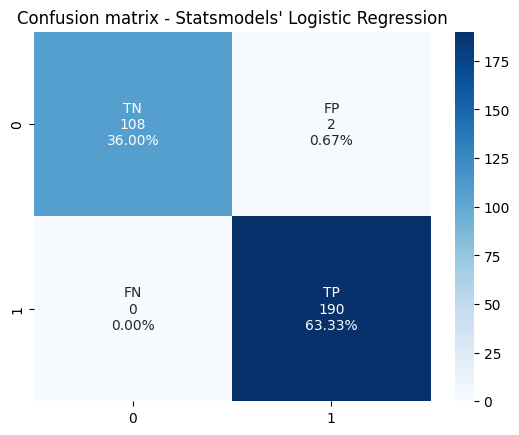

In [136]:
#Calculate précision, recall and ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# Viez the confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title("Confusion matrix - Statsmodels' Logistic Regression")
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Test accuracy = ', accuracy_score(y_test, prediction))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

#### Accuracy
- The model is 99.3% accurate in its predictions - an excellent level of accuracy

#### Precision
- Precision concerns the proportion of tickets that were correctly identified as real.
- In this case, only two banknotes were wrongly identified as real when they were was fake. This means that the model has an accuracy of 98.96%.

#### Recall
- Recall concerns the proportion of banknotes correctly identified as counterfeit.
- In this case, all the banknotes identified as fake were actually fake.

#### ROC-AUC
- The closer a ROC-AUC score is to 1, the better. In this case the score is 0.99

### Model improvement - Class separation threshold

In [137]:
y_prob = sm_log_reg.predict(X_test)

for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred = (y_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print(f'Threshold {threshold} - Number of True Negatives = {tn}')
    print(f'Threshold {threshold} - Number of True Positives = {tp}')
    print(f'Threshold {threshold} -# Number of False Negatives = {fn}')
    print(f'Threshold {threshold} - Number of False Positives = {fp}')
    print('------------------------------------------------')

Threshold 0.3 - Number of True Negatives = 106
Threshold 0.3 - Number of True Positives = 190
Threshold 0.3 -# Number of False Negatives = 0
Threshold 0.3 - Number of False Positives = 4
------------------------------------------------
Threshold 0.4 - Number of True Negatives = 106
Threshold 0.4 - Number of True Positives = 190
Threshold 0.4 -# Number of False Negatives = 0
Threshold 0.4 - Number of False Positives = 4
------------------------------------------------
Threshold 0.5 - Number of True Negatives = 108
Threshold 0.5 - Number of True Positives = 190
Threshold 0.5 -# Number of False Negatives = 0
Threshold 0.5 - Number of False Positives = 2
------------------------------------------------
Threshold 0.6 - Number of True Negatives = 108
Threshold 0.6 - Number of True Positives = 189
Threshold 0.6 -# Number of False Negatives = 1
Threshold 0.6 - Number of False Positives = 2
------------------------------------------------
Threshold 0.7 - Number of True Negatives = 110
Threshold

Test accuracy =  0.9966666666666667
Precision : 1.0000
Recall : 0.9947
ROC-AUC score : 0.9973684210526316


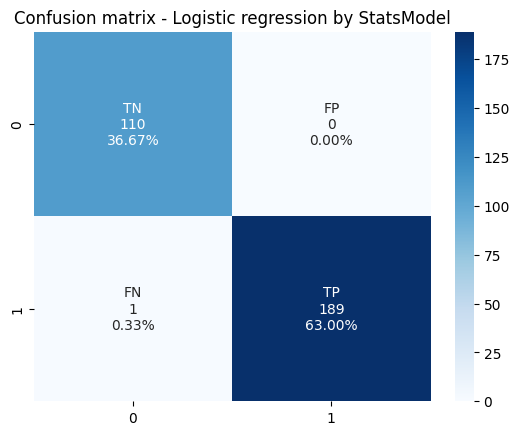

In [138]:
#Define threshold
y_pred = (y_prob > 0.7).astype(int)

# Round the prediction to the nearest number (0 or 1)
prediction = list(map(round, y_pred)) 
cm = confusion_matrix(y_test, prediction)  

#Calculate precision, recall and ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# View the confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Confusion matrix - Logistic regression by StatsModel')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Test accuracy = ', accuracy_score(y_test, prediction))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

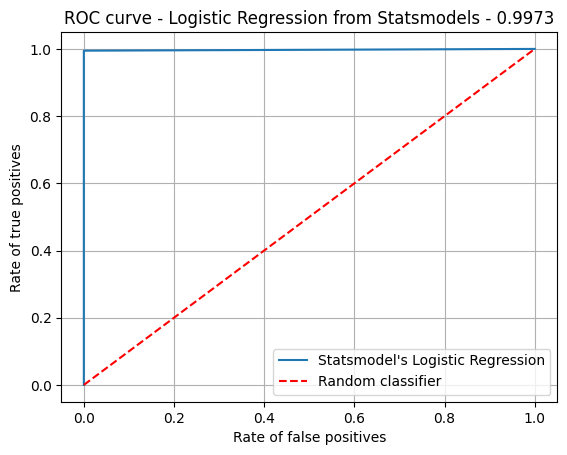

In [139]:
# Round the prediction to the nearest number (0 or 1)
prediction = list(map(round, y_pred)) 
sm_fpr, sm_tpr, sm_thresholds = roc_curve(y_test, prediction)

# View the ROC curve
import matplotlib.pyplot as plt
plt.plot(sm_fpr, sm_tpr, label="Statsmodel's Logistic Regression")
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Random classifier')
plt.grid()
plt.title("ROC curve - Logistic Regression from Statsmodels - 0.9973")
plt.xlabel("Rate of false positives")
plt.ylabel("Rate of true positives")

plt.legend()
plt.show()

# <span style="color:blue;">2. Scikit-Learn - Logistic Regression</span>

In [140]:
#Create scaler
scaler = StandardScaler()
billets.drop(columns='is_genuine')

# Define the predictive variables
X = billets.drop(columns='is_genuine')
X_scaled = scaler.fit_transform(X)
y = billets['is_genuine']

# Divide the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Find the most relevant values

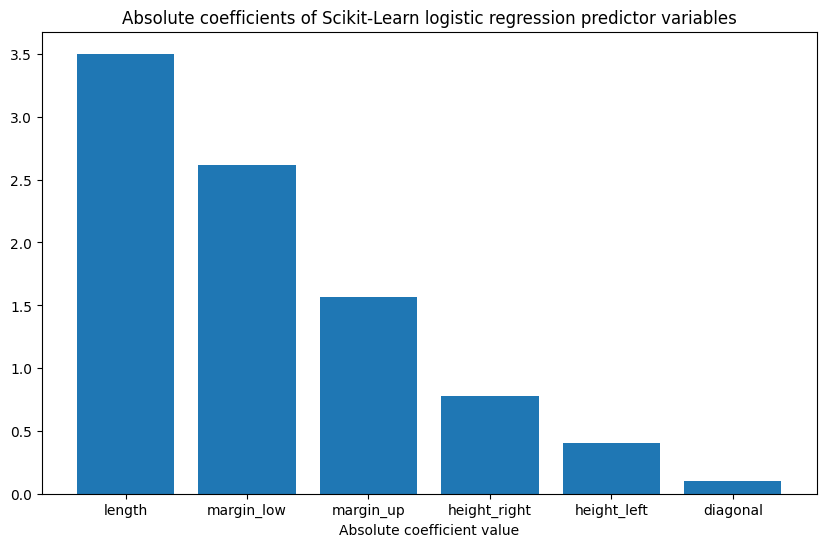

In [141]:
# Create the model
sk_log_reg = LogisticRegression(random_state = 42)

# Train the model
sk_log_reg.fit(X_train, y_train)

# Find the coefficients for each predictor variable
coefficients = sk_log_reg.coef_[0]

# Create a dataframe with the variables and their coefficients
coefficients_df = pd.DataFrame({'Variable': billets.drop(columns='is_genuine').columns, 'Coefficient': coefficients})

# Change coefficient values to absolute values
coefficients_df['CoefficientMagnitude'] = abs(coefficients_df['Coefficient'])

# Sort the dataframe in descending order
coefficients_df = coefficients_df.sort_values(by='CoefficientMagnitude', ascending=False)

# View absolute values of variables
plt.figure(figsize=(10, 6))
plt.bar(coefficients_df['Variable'], coefficients_df['CoefficientMagnitude'])
plt.xlabel('Absolute coefficient value')
plt.title('Absolute coefficients of Scikit-Learn logistic regression predictor variables')
plt.show()

The most relevant values seem to be 'length', 'margin_low' and 'margin_up'

In [142]:
# Create the predicted class labels for each banknote in X_test
y_pred = sk_log_reg.predict(X_test)

# Create predicted probabilities for each class for each banknote in X_test
y_proba = sk_log_reg.predict_proba(X_test)


In [143]:
print('Length, margin_low, margin_up, height_right, height_left, diagonal :')
print('Accuracy =', accuracy_score(y_test, y_pred))
print("Precision =", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print("ROC AUC Score = ", roc_auc_score(y_test, y_pred))
print('---------------')

#Columns sorted in descending order of influence on 'is_genuine'
del_columns = ['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']

#Variable names in each iteration
name = ['Length, margin_low, margin_up, height_right, height_left :', 
        'Length, margin_low, margin_up, height_right :',
        'Length, margin_low, margin_up:', 
        'Length, margin_low :',
        'Length :']

#Create the dataframes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Function to find the most relevant variables for the model
for col, nom in zip(del_columns, name):
    X_train_df = X_train_df.drop(columns=col)
    X_test_df = X_test_df.drop(columns=col)

    sk_log_reg.fit(X_train_df, y_train)

    y_pred = sk_log_reg.predict(X_test_df)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)    
    roc_auc = roc_auc_score(y_test, y_pred)

    print(nom)
    print('Accuracy =', acc)
    print("Precision =", precision)
    print("Recall = ", recall)
    print("ROC AUC Score = ", roc_auc)
    print('---------------')

Length, margin_low, margin_up, height_right, height_left, diagonal :
Accuracy = 0.9933333333333333
Precision = 0.9895833333333334
Recall =  1.0
ROC AUC Score =  0.9909090909090909
---------------
Length, margin_low, margin_up, height_right, height_left :
Accuracy = 0.9933333333333333
Precision = 0.9895833333333334
Recall =  1.0
ROC AUC Score =  0.9909090909090909
---------------
Length, margin_low, margin_up, height_right :
Accuracy = 0.99
Precision = 0.9844559585492227
Recall =  1.0
ROC AUC Score =  0.9863636363636364
---------------
Length, margin_low, margin_up:
Accuracy = 0.9933333333333333
Precision = 0.9895833333333334
Recall =  1.0
ROC AUC Score =  0.9909090909090909
---------------
Length, margin_low :
Accuracy = 0.9866666666666667
Precision = 0.979381443298969
Recall =  1.0
ROC AUC Score =  0.9818181818181818
---------------
Length :
Accuracy = 0.9533333333333334
Precision = 0.94
Recall =  0.9894736842105263
ROC AUC Score =  0.9401913875598086
---------------


The three models with the best scores are the model with *length, margin_low, margin_up, height_right, height_left, and diagonal* as variables, the model with *length, margin_low, margin_up, height_right, and height_left* as variables and the model with * length, margin_low, and margin_up* as variables.

All three models have the same scores - so I will use the model with the fewest variables. This has the added benefit of simplifying my model and reducing the risk of overfitting. So I'm going to train the model with these variables.

In [144]:
# Define predictive variables
X = billets[['margin_low','margin_up','length']]
y = billets['is_genuine']

# Divide the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
sk_log_reg = LogisticRegression(random_state = 42)

# Train the model
sk_log_reg.fit(X_train, y_train)

# Create the predicted class labels for each ticket in X_test
y_pred = sk_log_reg.predict(X_test)

### Accuracy, Precision, Recall and ROC-AUC

Test accuracy =  0.99
Precision : 0.9845
Recall : 1.0000
ROC-AUC score : 0.9863636363636364


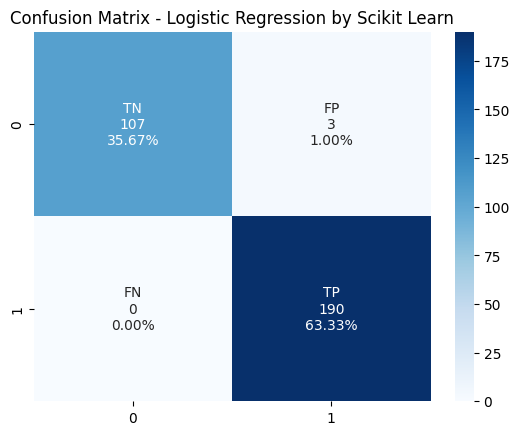

In [145]:
#Calculate precision, recall and ROC-AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred)  

# View the confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Confusion Matrix - Logistic Regression by Scikit Learn')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Test accuracy = ', accuracy_score(y_test, y_pred))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

#### Accuracy
- The model is 99% accurate in its predictions - 0.3% less than the accuracy of the Statsmodels model

#### Precision
- Accuracy concerns the proportion of banknotes that were correctly identified as real.
- In this case, 3 banknotes were wrongly identified as real when they were fake. This means that the model has an accuracy of 98.45%.

#### Recall
- Recall concerns the proportion of banknotes correctly identified as counterfeit.
- In this case, all the notes identified as fake were actually fake.

#### ROC-AUC
- The closer a ROC-AUC score is to 1, the better. In this case the score is 0.986

This model identified 3 false positives, i.e. 3 tickets were labeled as real even though they were false.
It did not identify any false negatives.

### Model improvement - Class separation threshold

Overall, these are very good scores.

However, precision is tailored to minimize false positives, while recall is tailored to minimize false negatives. Accuracy is important in this model, because we want to avoid fake banknotes being identified as real ones as much as possible. Maybe I can improve the accuracy score?

In [146]:
# Find the probability of class 1
y_hat_proba = sk_log_reg.predict_proba(X_test)[:,1]

# Try the different thresholds
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred = [ 0 if value < threshold else 1 for value in y_hat_proba ]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print(f'Seuil {threshold} - Number of true negatives = {tn}')
    print(f'Seuil {threshold} - Number of true positives = {tp}')
    print(f'Seuil {threshold} - Number of false negatives = {fn}')
    print(f'Seuil {threshold} - Number of false positives = {fp}')
    print('------------------------------------------------')

Seuil 0.3 - Number of true negatives = 102
Seuil 0.3 - Number of true positives = 190
Seuil 0.3 - Number of false negatives = 0
Seuil 0.3 - Number of false positives = 8
------------------------------------------------
Seuil 0.4 - Number of true negatives = 105
Seuil 0.4 - Number of true positives = 190
Seuil 0.4 - Number of false negatives = 0
Seuil 0.4 - Number of false positives = 5
------------------------------------------------
Seuil 0.5 - Number of true negatives = 107
Seuil 0.5 - Number of true positives = 190
Seuil 0.5 - Number of false negatives = 0
Seuil 0.5 - Number of false positives = 3
------------------------------------------------
Seuil 0.6 - Number of true negatives = 108
Seuil 0.6 - Number of true positives = 190
Seuil 0.6 - Number of false negatives = 0
Seuil 0.6 - Number of false positives = 2
------------------------------------------------
Seuil 0.7 - Number of true negatives = 108
Seuil 0.7 - Number of true positives = 190
Seuil 0.7 - Number of false negatives 

A threshold of 0.6 has a 0 false negatives and 1 false positive (compared to 3 false positives with a threshold of 0.5). I'm going to examine this in more detail.

In [147]:
# Find the predicted classes for a threshold of 0.6
prediction = [0 if value < 0.6 else 1 for value in y_hat_proba]
 
# Create a confusion matrix
cm = confusion_matrix(y_test, prediction) 

Accuracy =  0.9933333333333333
Precision : 0.9896
Recall : 1.0000
ROC-AUC score : 0.9909090909090909


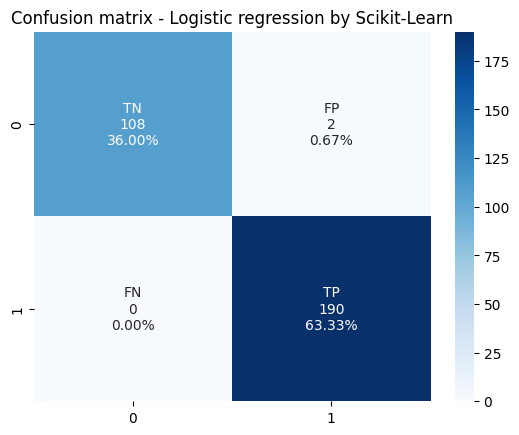

In [148]:
#Calculate precision, recall and ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# VView the confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Confusion matrix - Logistic regression by Scikit-Learn')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Accuracy = ', accuracy_score(y_test, prediction))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

Scikit-Learn's model is worse than that of Statsmodel as Statsmodel is better at identifying fake banknotes.

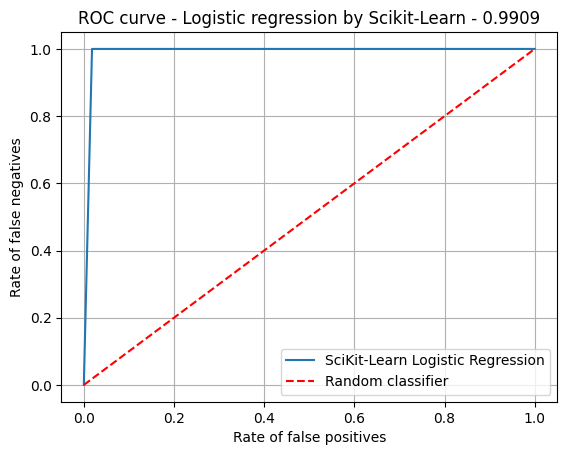

In [149]:
# View the ROC curve
prediction = [0 if value < 0.6 else 1 for value in y_hat_proba]
sk_fpr, sk_tpr, sk_thresholds = roc_curve(y_test, prediction)
plt.plot(sk_fpr, sk_tpr, label='SciKit-Learn Logistic Regression')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Random classifier')
plt.grid()
plt.title("ROC curve - Logistic regression by Scikit-Learn - 0.9909")
plt.xlabel("Rate of false positives")
plt.ylabel("Rate of false negatives")

plt.legend()
plt.show()

## K-means clustering

I will now create a k-means model and compare it to the 2 logistic regressions.

In [150]:
# Normalise and define the predictive variables
X = billets[['diagonal','height_left','height_right','margin_low','margin_up','length']]

#Start the scaler
std_scale = preprocessing.StandardScaler()

#Train the scaler
std_scale.fit(X)

#Transform the data
X_scaled = std_scale.transform(X)

# Defne the target variable
y= billets.is_genuine.values

# Divide the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

With this project, I don't need to use the elbow method, because I know I want to find two clusters - one for the real notes and one for the fake notes.

In [151]:
# Create a k-means with 2 clusters
kmeans = KMeans(n_clusters=2,n_init=10, random_state=42)

# Train it with X_train
kmeans.fit(X_scaled)

# Store labels in variable 'labels'
labels = kmeans.labels_ + 1

# Store centroids in variable 'centroids'
centroids = kmeans.cluster_centers_

In [152]:
#Create a PCA and train it
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [153]:
#Project the points into the new space
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2"])
X_proj[:10]

,PC1,PC2
0,1.647277,0.747301
1,-2.019805,-2.206729
2,-0.969101,2.619251
3,-1.375780,-1.817566
4,0.150302,-0.566044
5,-0.695930,0.426945
6,0.176100,1.302713
7,-1.151185,-0.382759
8,-0.854144,1.443684
9,-0.596853,1.743484


In [154]:
# Use the scaler with the centroids 
centroids_scaled = scaler.fit_transform(centroids)

# Use the PCA with the centroids
centroids_proj = pca.transform(centroids_scaled)

# Create a df with centroids_proj
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns = ["F1", "F2"], 
                              index=["cluster_0", "cluster_1"])

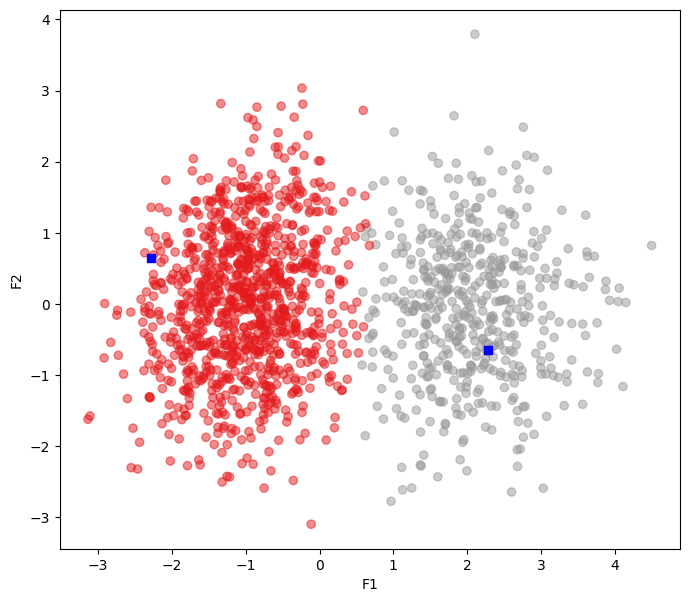

In [155]:
# Create a scatterplot including centroids
#Define the axes and figure size
fig, ax = plt.subplots(1,1, figsize=(8,7))

# Show individuals, with 50% transparency
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# Show the centroids in black and as sqaures
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s", c="blue" )

# Show the graph
ax.set_xlabel("F1")
ax.set_ylabel("F2")
plt.show()

In [156]:
#Create a k-means with 2 clusters and with a random_state of 2 in order to be sure
# that the clusters match the values 0 and 1 of the banknotes
kmeans = KMeans(n_clusters=2,n_init=10, random_state=2)

# The the model with X_train
kmeans.fit(X_train)

KMeans(n_clusters=2, n_init=10, random_state=2)

I will predict whether a banknote is real or fake based on the centroid closest to the banknote.

In [157]:
y_pred = kmeans.predict(X_test)

# Round the prediction to the closest number (0 or 1)
prediction = list(map(round, y_pred)) 
 
# Create a confusion matrix 
cm = confusion_matrix(y_test, prediction) 

Accuracy =  0.9866666666666667
Precision : 0.9949
Recall : 0.9848
ROC-AUC score : 0.9875222816399287


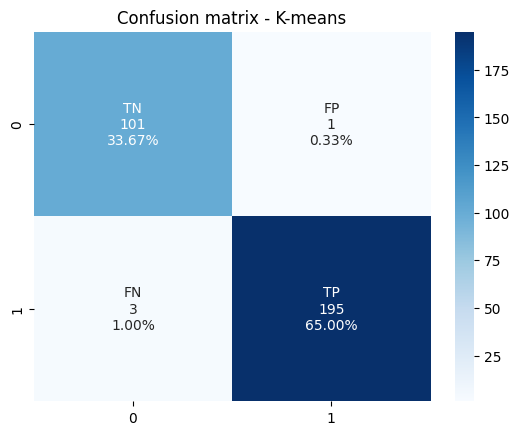

In [158]:
#Calculate precision, recall and ROC-AUC
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
roc_auc = roc_auc_score(y_test, prediction)

# View the confusion matrix
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]  # Added a space here
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.title('Confusion matrix - K-means')
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

print('Accuracy = ', accuracy_score(y_test, prediction))
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print("ROC-AUC score :", roc_auc)

This model is worse than both logistic regression models.

#### Accuracy
- The model is 98.6% accurate in its predictions

#### Precision
- Precision refers to the proportion of banknotes that were correctly identified as real.
- In this case, 4 banknotes were wrongly identified as real when they were fake. This means that the model has an accuracy of 98.02%.

#### Recall
- Recall refers to the proportion of banknotes correctly identified as counterfeit.
- In this case, all the notes identified as fake were actually fake.

#### ROC-AUC
- The closer a ROC-AUC score is to 1, the better. In this case the score is 0.987

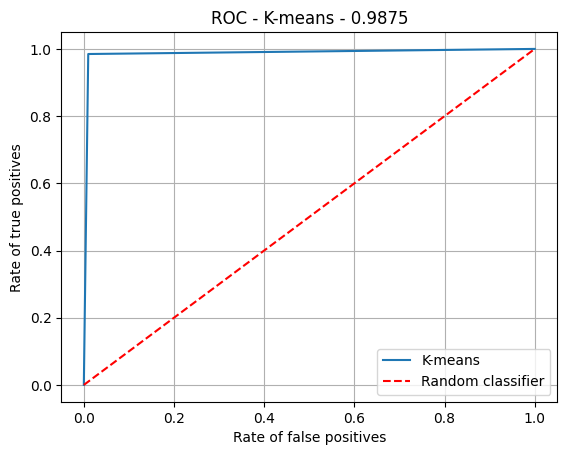

In [159]:
prediction = kmeans.predict(X_test)
km_fpr, km_tpr, km_thresholds = roc_curve(y_test, prediction)

# View the ROC curve
import matplotlib.pyplot as plt
plt.plot(km_fpr, km_tpr, label='K-means')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Random classifier')
plt.grid()
plt.title("ROC - K-means - 0.9875")
plt.xlabel("Rate of false positives")
plt.ylabel("Rate of true positives")

plt.legend()
plt.show()

# Conclusions

In [160]:
# Scikit-Learn LOGREG
# Define the predictive variables
X = billets[['margin_low','margin_up','length']]
y = billets['is_genuine']
# Divide the data into test and train sets
sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sk_log_reg = sk_log_reg.fit(sk_X_train, sk_y_train)

y_hat_proba = sk_log_reg.predict_proba(sk_X_test)[:,1]

sk_prediction = [0 if value < 0.6 else 1 for value in y_hat_proba]
              
sk_fpr, sk_tpr, sk_thresholds = roc_curve(sk_y_test, sk_prediction)



In [161]:
# STATSMODELS LOGREG
# Define the predictive variables
X = billets[['height_right','margin_low','margin_up','length']]
# Divide the data into test and train sets
sm_X_train, sm_X_test, sm_y_train, sm_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm_log_reg = sm.Logit(sm_y_train, sm_X_train).fit()

y_prob = sm_log_reg.predict(sm_X_test)

y_pred = (y_prob > 0.7).astype(int)

# Round the prediction to the nearest number (0 or 1)
sm_prediction = list(map(round, y_pred)) 
sm_fpr, sm_tpr, sm_thresholds = roc_curve(sm_y_test, sm_prediction)

Optimization terminated successfully.
         Current function value: 0.030209
         Iterations 11


In [162]:
# K-MEANS
# Define the predictive variables
X = billets[['diagonal','height_left','height_right','margin_low','margin_up','length']]

# Divide the data into test and train sets
km_X_train, km_X_test, km_y_train, km_y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Create a k-means with 2 clusters
kmeans = KMeans(n_clusters=2,n_init=10, random_state=2)

# Train the k-means with X_train
kmeans.fit(km_X_train)

km_prediction = kmeans.predict(km_X_test)
km_fpr, km_tpr, km_thresholds = roc_curve(km_y_test, km_prediction)

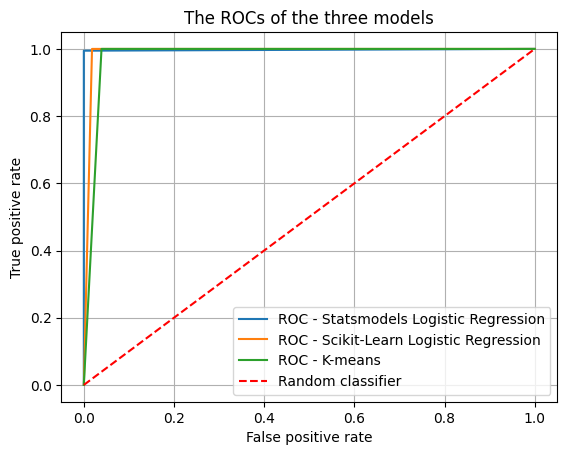

In [163]:
# View the ROC curves

plt.plot(sm_fpr, sm_tpr, label='ROC - Statsmodels Logistic Regression')
plt.plot(sk_fpr, sk_tpr, label='ROC - Scikit-Learn Logistic Regression')
plt.plot(km_fpr, km_tpr, label='ROC - K-means')
diagonal_line = np.linspace(0, 1)
plt.plot(diagonal_line, diagonal_line, linestyle='--', color='red', label='Random classifier')
plt.legend()
plt.grid()
plt.title("The ROCs of the three models")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.show()

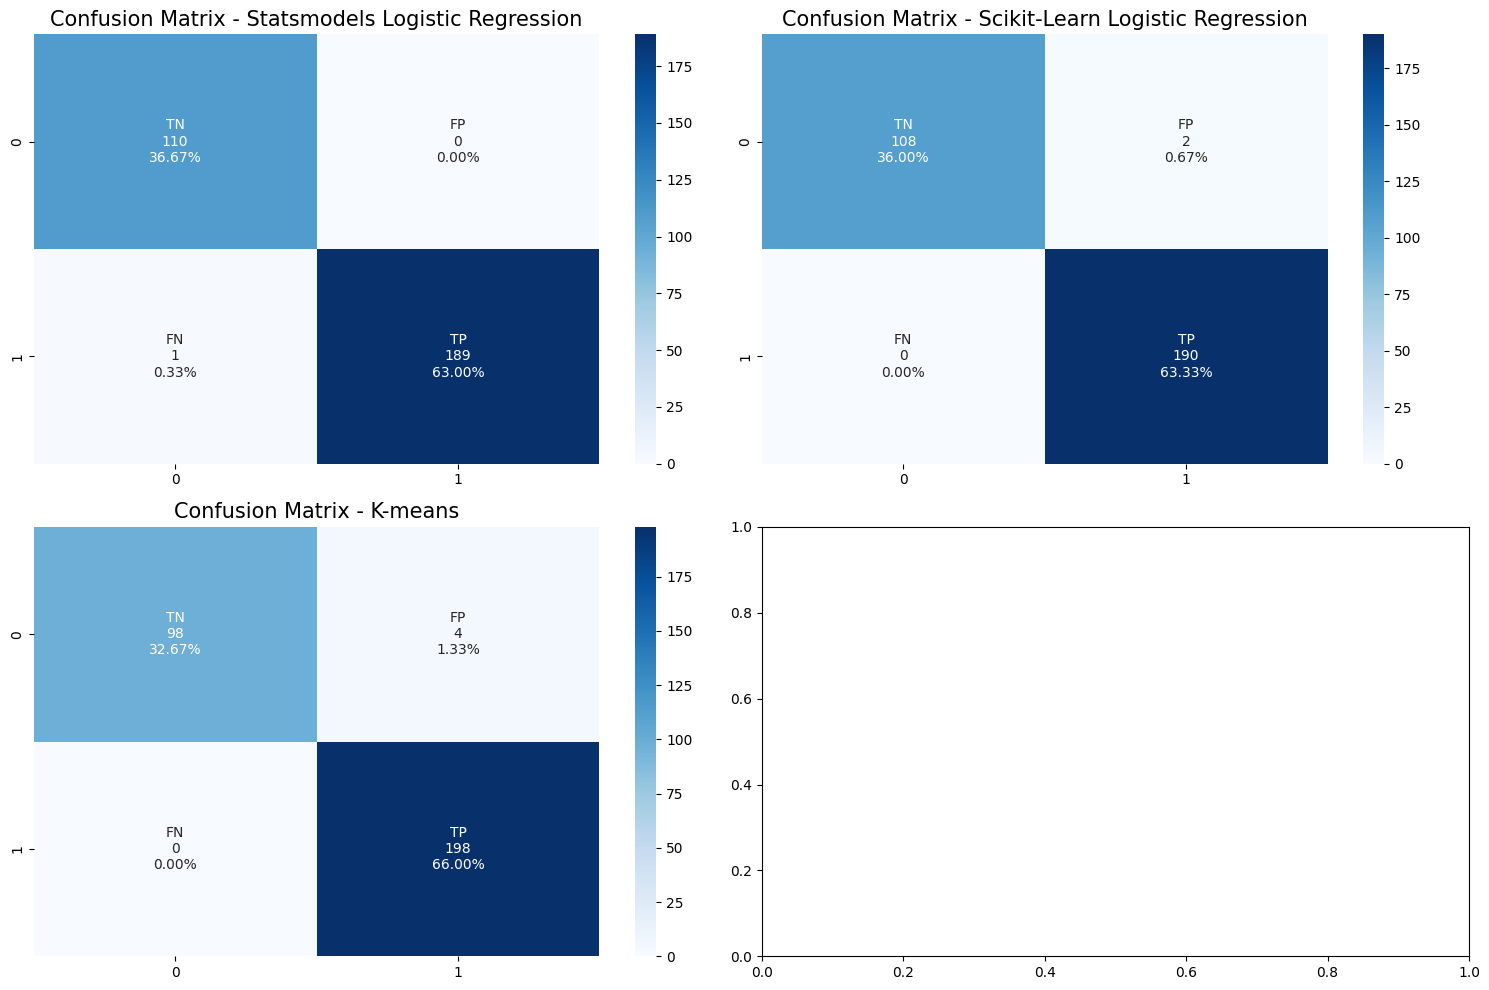

In [164]:
cm_values = [{'y_test': sm_y_test, 'prediction': sm_prediction}, {'y_test': sk_y_test, 'prediction': sk_prediction},{'y_test': km_y_test, 'prediction': km_prediction}]
names = ['Statsmodels Logistic Regression', 'Scikit-Learn Logistic Regression', 'K-means']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, cm_value) in enumerate(zip(names, cm_values)):
    cm = confusion_matrix(cm_value['y_test'], cm_value['prediction'])
    ax = axes[i]
    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    ax.set_title(f'Confusion Matrix - {name}', size=15)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax)

plt.tight_layout()
plt.show()

In [165]:
analyse_values = [{'y_test': sm_y_test, 'prediction': sm_prediction}, {'y_test': sk_y_test, 'prediction': sk_prediction},{'y_test': km_y_test, 'prediction': km_prediction}]
names = ['Statsmodels Logistic Regression', 'Scikit-Learn Logistic Regression', 'K-means']

for (name, analyse_value) in (zip(names, analyse_values)):
    print(name)
    print('Accuracy = ', accuracy_score(analyse_value['y_test'], analyse_value['prediction']))
    print('Precision = ', precision_score(analyse_value['y_test'], analyse_value['prediction']))
    print('Recall = ', recall_score(analyse_value['y_test'], analyse_value['prediction']))
    print('ROC-AUC = ', roc_auc_score(analyse_value['y_test'], analyse_value['prediction']))
    print('------------------------------------------------------')

Statsmodels Logistic Regression
Accuracy =  0.9966666666666667
Precision =  1.0
Recall =  0.9947368421052631
ROC-AUC =  0.9973684210526316
------------------------------------------------------
Scikit-Learn Logistic Regression
Accuracy =  0.9933333333333333
Precision =  0.9895833333333334
Recall =  1.0
ROC-AUC =  0.9909090909090909
------------------------------------------------------
K-means
Accuracy =  0.9866666666666667
Precision =  0.9801980198019802
Recall =  1.0
ROC-AUC =  0.9803921568627452
------------------------------------------------------


#### Conclusions:
- The best model is logistic regression from Statsmodels:
     - The best accuracy score
     - Best accuracy score
     - The best ROC-AUC score
     - Despite one false negative, this model offers the best prediction capabilities.
 
- The least efficient model is the k-means method. The ROC-AUC, accuracy and precision scores are all the worst scores of the 3 models.

# Model - Predictive Analysis

In [166]:
# Define the predictive variables
X = billets[['height_right','margin_low','margin_up','length']]
y = billets.is_genuine

# Divide the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
sm_log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.030209
         Iterations 11


In [167]:
files = ['billets_production.csv']

for file in files:
    valeurs_soutenance = pd.read_csv(file)
    valeurs_à_prédire = valeurs_soutenance[['height_right','margin_low','margin_up','length']]
    y_prob = sm_log_reg.predict(valeurs_à_prédire)
    y_pred = (y_prob > 0.7).astype(int)
    prediction = list(map(round, y_pred))
    result_df = pd.DataFrame({'ID': valeurs_soutenance['id'],'Predicted': prediction, 'y prob': y_prob})
    result_df.loc[result_df['Predicted']==0, 'Predicted']='Faux'
    result_df.loc[result_df['Predicted']==1, 'Predicted']='Vrai'

display(result_df)

C:\Users\floss\AppData\Local\Temp\ipykernel_732\4182909275.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Faux' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[result_df['Predicted']==0, 'Predicted']='Faux'


,ID,Predicted,y prob
0,A_1,Faux,0.000499
1,A_2,Faux,0.000009
2,A_3,Faux,0.000039
3,A_4,Vrai,0.987140
4,A_5,Vrai,0.999989
